In [239]:
import pandas as pd

dataset_path = {'pent':'ppentreprise_data.csv', 'pproduit':'presentation_produit_data.csv', 'oemploie':'offre_emploie_data.csv', 'pmetier':'presentation_metier_data.csv', 'temoignage':'temoignage_clients_data.csv', 'tuto':'tuto_data.csv'}

dfs = {}

for key, path in dataset_path.items():
    print(f'_______________________ Analyzing dataset {path} ___________________________________')
    dfs[key] = pd.read_csv('./cleaned_dataset/' + path, delimiter=';')
    print(dfs[key].head())

# we are going to concatenate all the data 
concat_df = pd.concat([dfs['pent'], dfs['pproduit'],  dfs['pmetier'], dfs['temoignage'], dfs['tuto'], dfs['oemploie']], axis=0, sort=True)


_______________________ Analyzing dataset ppentreprise_data.csv ___________________________________
   Unnamed: 0         link                                              title  \
0           0    PAeQD_64x                   Présentation Entreprise Rousseau   
1           1   QfCHZX1PnP              Présentation de l'entreprise Boréalie   
2           2  MWsdG52R9uQ   Brasserie Lambelin: Présentation de l'entreprise   
3           3   D264CLOFKE                   Présentation de l'entreprise DBC   
4           4  gVmZc9hx7X8  Film institutionnel de présentation du groupe ...   

                                         description                 category  \
0  Fondée en 1976, Rousseau est une entreprise de...  présentation entreprise   
1  Présentation de l'entreprise Boréalie cosmétiq...  présentation entreprise   
2  Présentation de "Brasserie Lambelin" à l'occas...  présentation entreprise   
3  Visite de la société DBC, spécialiste de l'usi...  présentation entreprise   
4  Décou

In [240]:
concat_df.shape


(2218, 8)

In [241]:
concat_df = concat_df[concat_df['transcriptions'] != ' ']
concat_df.shape

(1599, 8)

In [242]:
x_train = concat_df['transcriptions'].values

In [243]:
concat_df['category'].value_counts()

presentation metier        619
temoignage                 280
offre emploie              223
tutoriel                   183
présentation entreprise    150
presentation produit       144
Name: category, dtype: int64

In [244]:
concat_df['category'].describe()


count                    1599
unique                      6
top       presentation metier
freq                      619
Name: category, dtype: object

In [260]:
concat_df.to_csv('cleaned_dataset/easyMovieCategory_dataset.csv', sep=';', header=True,  mode='w')

We are going to train a TF-IDF+LinearSVC model on it. But first we need to clean the data.
We use the previously build pipline to clean and train the model. 

The dataset is not well balanced.

# Clean the data 

The first step we are going to use spacy to clean the data by :

* lower all the word to avoid that word like : Hello HELLO or hello are 
considered as 3 differents words.
* removing stop words 
* removing punctuation 
* lemming 


Note : In the second part we will do the same without lemming to see the performance.


In [289]:
# create a copy of the dataset 
x = concat_df['transcriptions'].values
target = concat_df['category'].values

In [248]:
import numpy as np

category = np.unique(concat_df['category'].values)

In [290]:
from sklearn.preprocessing import LabelEncoder

encodage = LabelEncoder()
target = encodage.fit_transform(target)

In [291]:
category = encodage.fit_transform(category)

In [292]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, target, random_state=42, test_size=0.3, shuffle=True)

We will implement the same function but without lemming. We could add a boolean variable to indicate if we do lemming or not but for performance reason I prefer to implement an other function.

Let's test this one 


In [252]:
x_train.shape


(1119,)

In [253]:
from sklearn.svm import LinearSVC

In [254]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.svm import LinearSVC

from sklearn.pipeline import Pipeline

linear_clf = Pipeline([('vect', CountVectorizer()),
                      ('tfidf', TfidfTransformer()),
                      ('clf', LinearSVC())])

In [255]:
linear_clf.fit(x_train, y_train)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...ax_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))])

In [256]:
predicted = linear_clf.predict(x_test)

In [257]:
from sklearn.metrics import precision_recall_fscore_support

precision_recall_fscore_support(y_test, predicted, average='weighted')

(0.8432075345619748, 0.84375, 0.840136126556823, None)

In [258]:
from sklearn.metrics import classification_report

score = classification_report(y_pred=predicted, y_true=y_test, labels=category)

In [259]:
print(score)



              precision    recall  f1-score   support

           0       0.96      0.77      0.86        62
           1       0.85      0.95      0.90       186
           2       0.70      0.60      0.64        47
           3       0.76      0.63      0.69        41
           4       0.87      0.87      0.87        76
           5       0.82      0.90      0.86        68

   micro avg       0.84      0.84      0.84       480
   macro avg       0.83      0.79      0.80       480
weighted avg       0.84      0.84      0.84       480



In [295]:
# cross validation
from sklearn.model_selection import cross_validate

cross_model = Pipeline([('vect', CountVectorizer()),
                      ('tfidf', TfidfTransformer()),
                      ('clf', LinearSVC())])
score = cross_validate(cross_model, x_train, y_train, n_jobs=-1, verbose=1)

/Users/remy.d.w/Library/Python/3.6/lib/python/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.3s finished


In [305]:
import seaborn as sns 

cross_val_score_df = pd.DataFrame(score)
cross_val_score_df['step'] = [1, 2, 3]

/Users/remy.d.w/Library/Python/3.6/lib/python/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


In [306]:
cross_val_score_df.head()

,fit_time,score_time,test_score,train_score,step
0,0.432111,0.156821,0.811170,0.998654,1
1,0.462586,0.135756,0.801075,0.995984,2
2,0.454912,0.174283,0.816712,0.994652,3


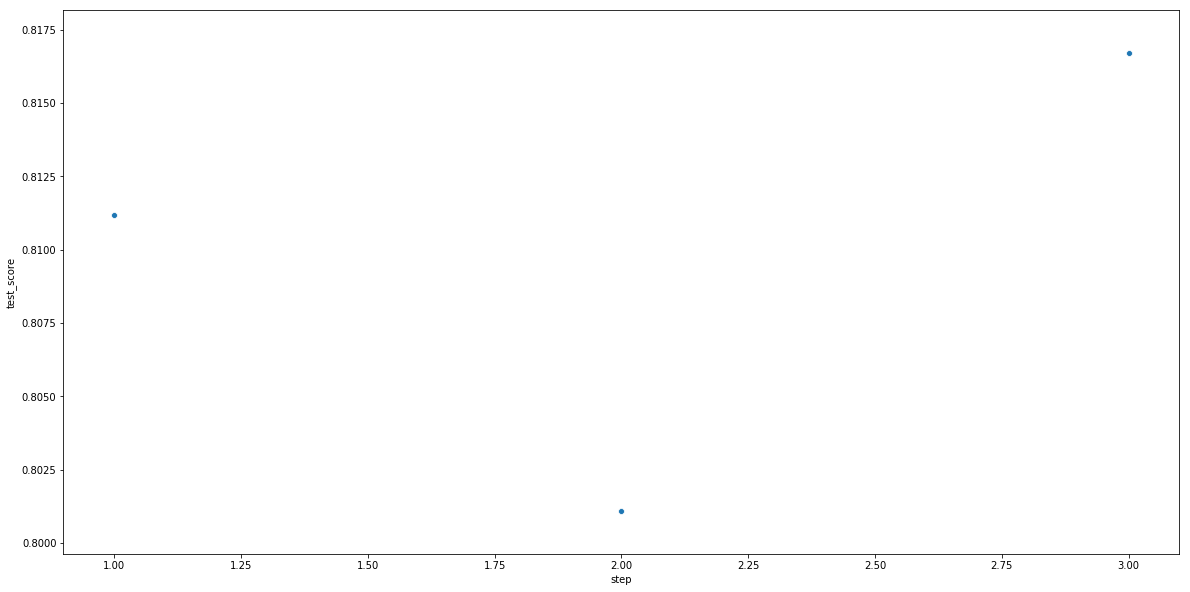

In [308]:
sns.scatterplot(x='step', y='test_score', data=cross_val_score_df,)


# Doc2Vec

In [ ]:
import spacy
from spacy.lang.fr import French
spacy.cli.download("fr_core_news_sm")

spacy_nlp = spacy.load('fr_core_news_sm')

In [ ]:
from spacy.lang.fr.stop_words import STOP_WORDS
stop_words = STOP_WORDS
punctuations = spacy.lang.punctuation.PUNCT


In [ ]:
def prepareText(text):
  """
  This function clean the text. 
  """

  processing = spacy_nlp(text)
  
  # lowering words and lemming 
  # strip space 
  # don't apply lemming if the word is a pronoun because spacy convert the word in "-PRON-" and we need all the word 
  processing = [ word.lemma_.lower() if word.lemma_ != "-PRON-" else word.lower_ for word in processing ] 

  # remove stop words and punctuation 

  processing = [word  for word in processing if (word not in stop_words and punctuations)]

  return processing  

In [261]:
# create a copy of x 

x_doc = x.copy()

In [262]:
for i in range(0, len(x_doc)) :
  x_doc[i] = prepareText(x_doc[i])

x_doc[0]


['[',
 'musiqu',
 ']',
 'brasserie',
 'lamblin',
 'entreprise',
 'familial',
 'créer',
 '150',
 'an',
 'alexis',
 'génération',
 'poursuivre',
 'aventuré',
 'métier',
 'métier',
 'approvisionner',
 'client',
 'café',
 'bar',
 'brasseries',
 'région',
 'livrer',
 'boisson',
 'consommateur',
 'final',
 'pouvoir',
 'passer',
 'moment',
 'agréable',
 '[',
 'musiqu',
 ']',
 'ambition',
 'brasserie',
 'lambelin',
 'acteur',
 'important',
 'chance',
 'jour',
 'croiser',
 'camion',
 'sillonner',
 'nord',
 'calais',
 'aller',
 'servir',
 '1000',
 'client',
 'client',
 'ambition',
 'faire',
 'vivre',
 'tissu',
 'régional',
 'travailler',
 'effectivement',
 'prestataire',
 'local',
 'fournisseur',
 'local',
 'mettre',
 'permettre',
 'contribuer',
 'développemer',
 'région',
 'origine',
 'avoisiner',
 'récupère',
 'fois',
 'fût',
 'caisse',
 'emballage',
 'consigner',
 'grand',
 'nouveauté',
 'mettre',
 'place',
 'yer',
 'an',
 'recyclage',
 'verre',
 'convaincre',
 'année',
 'venir',
 'sujet',
 '

In [263]:
x_doc_train, x_doc_test, y_doc_train, y_doc_test = train_test_split(x_doc, target, random_state=42, test_size=0.25, shuffle=True)

In [264]:
from gensim.models.doc2vec import TaggedDocument
# create a tagged object 
taggedDocument = [TaggedDocument(doc, [tag]) for doc, tag in zip(x_doc_train, y_doc_train)]

In [265]:
taggedDocument[0].tags



[1]

In [266]:
from gensim.models.doc2vec import Doc2Vec
import multiprocessing
cores = multiprocessing.cpu_count()

doc2vec = Doc2Vec(dm=1, vector_size=400, window=20, min_count=2, negative=5, hs=0, sample=0, workers=cores)


In [267]:
doc2vec.build_vocab(taggedDocument)


In [270]:
from tqdm import tqdm

max_epochs = 30

for epoch in tqdm(range(max_epochs)):
  doc2vec.train(taggedDocument, total_examples=len(taggedDocument), epochs=1)
  doc2vec.alpha -= 0.0002
  doc2vec.min_alpha = doc2vec.alpha


In [271]:
def vec_for_learning(doc2vec_model, tagged_docs):
    targets, regressors = zip(*[(doc.tags[0], doc2vec_model.infer_vector(doc.words, steps=20)) for doc in tqdm(tagged_docs)])
    return targets, regressors

In [272]:
from gensim.models.doc2vec import TaggedDocument
# create a tagged object 
taggedDocument_test = [TaggedDocument(doc, [tag]) for doc, tag in zip(x_doc_test, y_doc_test)]



In [273]:
y_tagged_doc_train, x_tagged_doc_train = vec_for_learning(doc2vec, taggedDocument)
y_tagged_doc_test, x_tagged_doc_test = vec_for_learning(doc2vec, taggedDocument_test)

100%|██████████| 400/400 [00:05<00:00, 66.78it/s]


In [274]:
model = LinearSVC()

model.fit(x_tagged_doc_train, y_tagged_doc_train)  
  
predicted = model.predict(x_tagged_doc_test)

# F1-Score & Recall & Precision 
score = classification_report(predicted, y_tagged_doc_test, labels=category)

print(f"Modele : {key} score : {score}")

Modele : tuto score :               precision    recall  f1-score   support

           0       0.55      0.34      0.42        88
           1       0.47      0.73      0.57       100
           2       0.30      0.22      0.25        50
           3       0.45      0.42      0.43        36
           4       0.67      0.56      0.61        77
           5       0.44      0.51      0.47        49

   micro avg       0.49      0.49      0.49       400
   macro avg       0.48      0.46      0.46       400
weighted avg       0.50      0.49      0.48       400



/Users/remy.d.w/Library/Python/3.6/lib/python/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)

In [277]:
doc_df = pd.DataFrame({'documents':x_tagged_doc_train, 'tags':y_tagged_doc_train})
doc_df.head()

,documents,tags
0,"[0.14775851, -0.60166067, 0.5370192, 0.7919182...",1
1,"[0.22108231, -0.23361762, 0.08218013, 0.849419...",1
2,"[0.6152724, -0.5414209, 0.29280955, 0.8376238,...",4
3,"[0.31837204, -0.22011542, 0.36869735, 0.596127...",1
4,"[0.03411482, -0.14625444, 0.31684896, 0.682640...",1


In [281]:
concat_df.head()

,Id,Unnamed: 0,Unnamed: 0.1,category,description,link,title,transcriptions
2,NaN,2.0,NaN,présentation entreprise,"Présentation de ""Brasserie Lambelin"" à l'occas...",MWsdG52R9uQ,Brasserie Lambelin: Présentation de l'entreprise,[Musique] la brasserie lamblin c'est une entre...
4,NaN,4.0,NaN,présentation entreprise,Découvrez notre premier rapport intégré sur \n...,gVmZc9hx7X8,Film institutionnel de présentation du groupe ...,Créée par des entrepreneurs\npour des entrepre...
6,NaN,6.0,NaN,présentation entreprise,NaN,9y6MHBWb_A8,RTBF : présentation de l'entreprise,jusqu'à 9 heures viva week-end philippe tu sai...
10,NaN,10.0,NaN,présentation entreprise,Découvrez les étapes de fabrication des portai...,N0ugA8uAHfA,TSCHOEPPE - Présentation d'entreprise - 2018,[Musique] bonjour je suis philippe je paie act...
12,NaN,12.0,NaN,présentation entreprise,RENZ _ fabricant de boites aux lettres et boit...,RLhvTYjlBVA,Renz - présentation entreprise - Soirée entrep...,bienvenue chez rain's les boîtes aux lettres i...


In [283]:
X = doc2vec[target]
reduced_embedding = tsne.fit_transform(X)

In [284]:
x_values = [vector[0] for vector in reduced_embedding]
y_values = [vector[1] for vector in reduced_embedding]
target_names = concat_df['category'].values

In [285]:
tnse_doc_df = pd.DataFrame({'x':x_values, 'y':y_values, 'tags':target_names})
tnse_doc_df.head()

,x,y,tags
0,23.305052,-23.093597,présentation entreprise
1,24.078497,-22.200068,présentation entreprise
2,24.078497,-22.200068,présentation entreprise
3,22.874569,-24.317190,présentation entreprise
4,24.078497,-22.200068,présentation entreprise


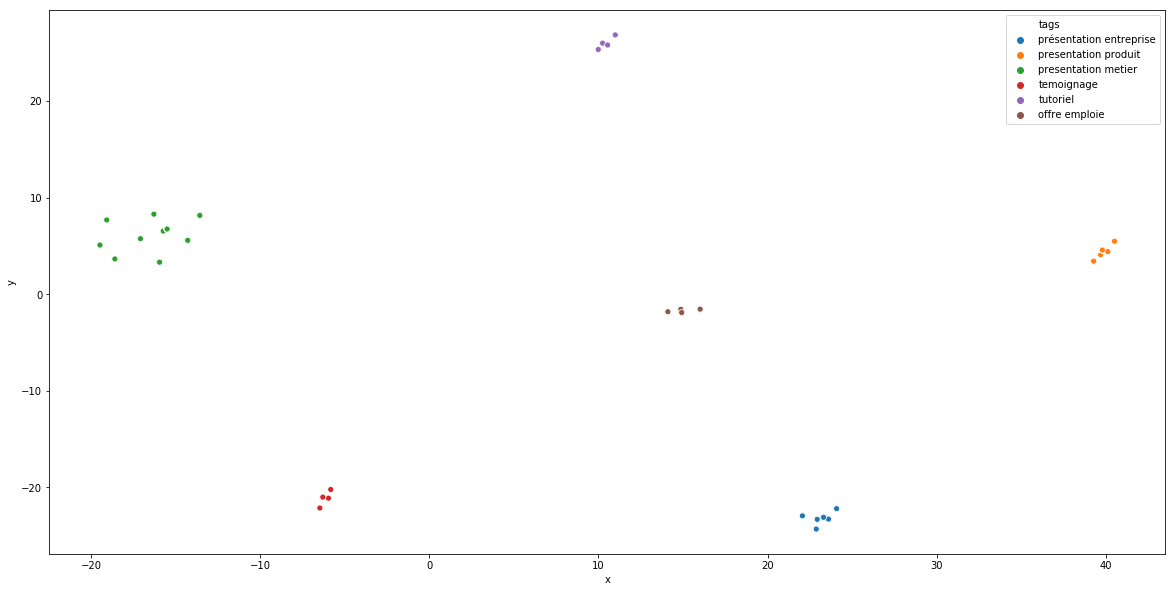

In [287]:
import matplotlib.pyplot as plt 
import seaborn as sns


plt.rcParams['figure.figsize']=20,10
sns.scatterplot(x='x', y='y', data=tnse_doc_df, hue='category')